# Feedforward Network with Credit Card Fraud

Let us look at a BigDL example with Credit Card Fraud.  We will train a simple, feedforward neural network with the credit card dataset.

Let's look briefly at the credit card dataset

| Time" | "V1"              | "V2"                | "V3"             | "V4"              | "V5"               | "V6"                | "V7"                | "V8"               | "V9"               | "V10"              | "V11"              | "V12"              | "V13"              | "V14"              | "V15"             | "V16"              | "V17"              | "V18"              | "V19"              | "V20"               | "V21"              | "V22"              | "V23"              | "V24"              | "V25"              | "V26"              | "V27"                | "V28"               | "Amount" | "Class" | 
|-------|-------------------|---------------------|------------------|-------------------|--------------------|---------------------|---------------------|--------------------|--------------------|--------------------|--------------------|--------------------|--------------------|--------------------|-------------------|--------------------|--------------------|--------------------|--------------------|---------------------|--------------------|--------------------|--------------------|--------------------|--------------------|--------------------|----------------------|---------------------|----------|---------| 
| 0     | -1.3598071336738  | -0.0727811733098497 | 2.53634673796914 | 1.37815522427443  | -0.338320769942518 | 0.462387777762292   | 0.239598554061257   | 0.0986979012610507 | 0.363786969611213  | 0.0907941719789316 | -0.551599533260813 | -0.617800855762348 | -0.991389847235408 | -0.311169353699879 | 1.46817697209427  | -0.470400525259478 | 0.207971241929242  | 0.0257905801985591 | 0.403992960255733  | 0.251412098239705   | -0.018306777944153 | 0.277837575558899  | -0.110473910188767 | 0.0669280749146731 | 0.128539358273528  | -0.189114843888824 | 0.133558376740387    | -0.0210530534538215 | 149.62   | 1       | 
| 0     | 1.19185711131486  | 0.26615071205963    | 0.16648011335321 | 0.448154078460911 | 0.0600176492822243 | -0.0823608088155687 | -0.0788029833323113 | 0.0851016549148104 | -0.255425128109186 | -0.166974414004614 | 1.61272666105479   | 1.06523531137287   | 0.48909501589608   | -0.143772296441519 | 0.635558093258208 | 0.463917041022171  | -0.114804663102346 | -0.183361270123994 | -0.145783041325259 | -0.0690831352230203 | -0.225775248033138 | -0.638671952771851 | 0.101288021253234  | -0.339846475529127 | 0.167170404418143  | 0.125894532368176  | -0.00898309914322813 | 0.0147241691924927  | 2.69     | 1       | 
| 1     | -1.35835406159823 | -1.34016307473609   | 1.77320934263119 | 0.379779593034328 | -0.503198133318193 | 1.80049938079263    | 0.791460956450422   | 0.247675786588991  | -1.51465432260583  | 0.207642865216696  | 0.624501459424895  | 0.066083685268831  | 0.717292731410831  | -0.165945922763554 | 2.34586494901581  | -2.89008319444231  | 1.10996937869599   | -0.121359313195888 | -2.26185709530414  | 0.524979725224404   | 0.247998153469754  | 0.771679401917229  | 0.909412262347719  | -0.689280956490685 | -0.327641833735251 | -0.139096571514147 | -0.0553527940384261  | -0.0597518405929204 | 378.66   | 1       | 


Notice the PCA dimensions here (Principal Component Analysis). PCA here is done for several reasons: as a dimensionality reduction technique, but also as a way to anonymize very sensitive financial data.

Of course, it would be better if we could see the actual dimensions, but on the ohter hand, the PCA dimensions should contain most of the "signal" of the original data.


In [1]:
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sn
import pandas as pd
import random as rd
import datetime as dt


from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from utils import *

from pyspark.sql.functions import col


init_engine()

In [ ]:
## Parameteters

We are using a very large batch size here because the dataset is very lopsided.

In [2]:
learning_rate = 0.1
training_epochs = 100
batch_size = 10000
display_step = 1

# Network Parameters
n_input = 29
n_classes = 2
n_hidden_1 = 10 # 1st layer number of features

LABELS = ["Normal", "Fraud"]

cols = ["V" + str(x) for x in list(range(1,28))] + ["Amount"]



### Sizing the Hidden Layer(s)

Sizing hidden layers can be a challenge.  The best way to figure this out is to do it
empirically.  However, we may need a "rule of thumb" to start.  Here is a good rule of thumb:

First Hidden Layer:
```
n_hidden_1 = np.sqrt(np.sqrt((n_classes + 2) * n_input) + 2 * np.sqrt(n_input /(n_classes+2.)))
```

Second Hidden Layer:  (if needed)
```
n_hidden_2 = n_classes * np.sqrt(n_input / (n_classes + 2.))
```

This dataset may not need two hidden layers. We'll start with one and see how that goes.

In [3]:
# Number of hidden layers

n_hidden_guess = np.sqrt(np.sqrt((n_classes + 2) * n_input) + 2 * np.sqrt(n_input /(n_classes+2.)))
print("Hidden layer 1 (Guess) : " + str(n_hidden_guess))

n_hidden_guess_2 = n_classes * np.sqrt(n_input / (n_classes + 2.))
print("Hidden layer 2 (Guess) : " + str(n_hidden_guess_2))


Hidden layer 1 (Guess) : 4.0193898071
Hidden layer 2 (Guess) : 5.38516480713


In [2]:
cc_training = spark.read.csv("../data/creditcardfraud/creditcard.csv", header=True, inferSchema="true", mode="DROPMALFORMED")

In [7]:
cc_training.select('Time', 'V1', 'V2', 'Amount', 'Class').describe().show()

+-------+-----------------+--------------------+--------------------+-----------------+-------------------+
|summary|             Time|                  V1|                  V2|           Amount|              Class|
+-------+-----------------+--------------------+--------------------+-----------------+-------------------+
|  count|           284807|              284807|              284807|           284807|             284807|
|   mean|       94813.8596|2.260907382386083...|6.067406817137794...|88.34961925095207|   1.00172748563062|
| stddev|47488.14595456619|  1.9586958038574867|  1.6513085794769937|250.1201092401879|0.04152718963546483|
|    min|                0|    -56.407509631329|   -72.7157275629303|              0.0|                  1|
|    max|           172792|    2.45492999121121|    22.0577289904909|         25691.16|                  2|
+-------+-----------------+--------------------+--------------------+-----------------+-------------------+



In [3]:
cc_training = cc_training.select([col(c).cast("double") for c in cc_training.columns])



In [4]:
cc_training.show()

+----+------------------+-------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+------+-----+
|Time|                V1|                 V2|                V3|                 V4|                 V5|                 V6|                  V7|                 V8|                V9|                V10|               V11|               V12|                V13|                V14|                V15|                V16|                 V17|                V18|                V19|                V20|                 V

## Lopsided Data distribution

Let us look at the very lopsided data distribution.

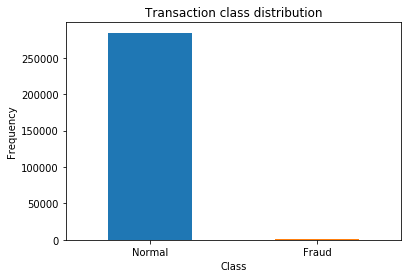

In [10]:
#count_classes = pd.value_counts(df['Class'], sort = True)
count_classes = pd.value_counts(cc_training.select('Class').toPandas()['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

### Splitting the data

Instead of using a random split, we are going to segment the dataset based on time. This is becaause a model will be trained on historical data and deployed on new data for prediction, so it makes sense for validation data to work much the same way.

In [6]:
# get the time to split the data.
splitTime = cc_training.stat.approxQuantile("Time", [0.7], 0.001)[0]

trainingData =cc_training.filter("Time < " + str(splitTime))
validData = cc_training.filter("Time >= " + str(splitTime))

### Converting to RDD of Sample

BigDL requires all input data to be in its native Sample format (for the RDD API).  The Pipeline api, shown in feedforward-iris-pipeline -- allows data to be in Spark Dataframes.

To convert the data into type Sample, we will use a helper method here to convert. The sample function requires two numpy arrays:

1. Feature array (of all the features in double type)
2. Label array: the label value (usually just a single number in the array).

Then we convert these to RDDs of type Sample.

In [7]:
#convert ndarray data into RDD[Sample]

# time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount,prediction
def array2rdd(ds):
    #build Sample from ndarrays
    def build_sample(time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount,prediction):
        feature = np.array([V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount]).flatten()
        label = np.array(prediction)
        return Sample.from_ndarray(feature, label)
    rdd = ds.map(lambda (time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount,prediction): build_sample(time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,amount,prediction))
    return rdd

cc_rdd_train = array2rdd(trainingData.rdd.map(list))
cc_rdd_train.cache()
print("Training Count:" + str(cc_rdd_train.count()))



cc_rdd_test = array2rdd(validData.rdd.map(list))
cc_rdd_test.cache()
print("Test Count:" + str(cc_rdd_test.count()))


Training Count:199152
Test Count:85655


## Setting up our network

Here we are going to actually set up our network.  It will be single hidden layer network, with input layer (based on our 4-inputs), and output layer (softmax with 3 classes).  

The hidden layer has been set up to 10, and we will use ReLU activation for that hidden layer. ReLU is currently preferred as a activation layer for these types of networks as it is linear in the postive direction, avoiding the vanishing gradient problem.



In [13]:
# Create model

def multilayer_perceptron(n_hidden_1, n_input, n_classes):
    # Initialize a sequential container
    model = Sequential()
    # Hidden layer with ReLu activation
    model.add(Linear(n_input, n_hidden_1).set_name('mlp_fc1'))
    model.add(ReLU())
    # output layer
    model.add(Linear(n_hidden_1, n_classes).set_name('mlp_fc3'))
    model.add(LogSoftMax())
    return model

model = multilayer_perceptron(n_hidden_1, n_input, n_classes)

creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createLogSoftMax


### Training the Model

Now we need to set up our training. We are going to use the following:

* Loss Function: ClassNLLCriterion
* Optimization: AdaGrad 

For validation, we will validating against top1Accuracy for every epoch.

In [14]:
# Create an Optimizer
optimizer = Optimizer(
    model=model,
    training_rdd=cc_rdd_train,
    criterion=ClassNLLCriterion(),
    optim_method=SGD(learningrate=learning_rate),
    end_trigger=MaxEpoch(training_epochs),
    batch_size=batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size=batch_size,
    val_rdd=cc_rdd_test,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy()]
)

app_name='creditcardfraud-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print("saving logs to ",app_name)

creating: createClassNLLCriterion
creating: createDefault
creating: createSGD
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
('saving logs to ', 'creditcardfraud-20171115-132426')


In [15]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print("Optimization Done.")

Optimization Done.
CPU times: user 60 ms, sys: 10 ms, total: 70 ms
Wall time: 3min 1s


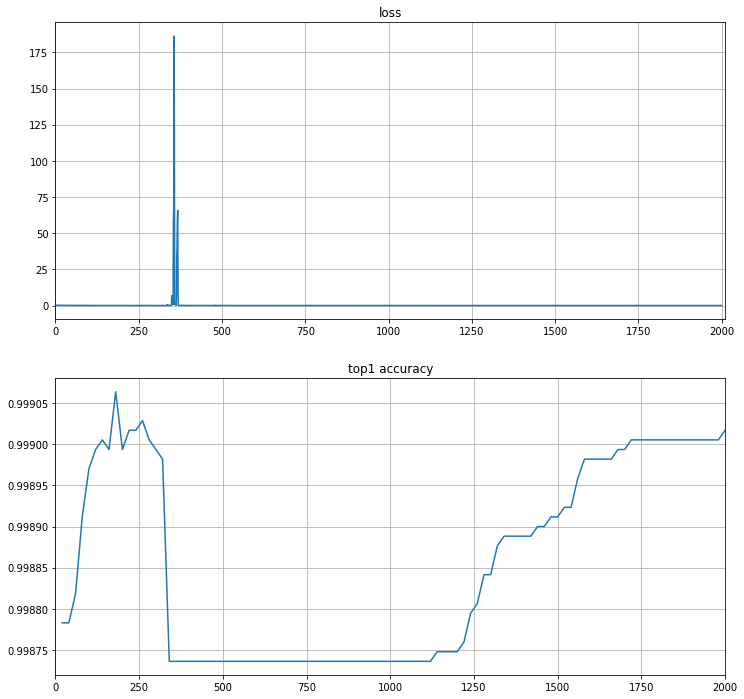

In [16]:

loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0])
plt.title("top1 accuracy")
plt.grid(True)

## See visualizations on tensorboard as well

We can run tensorboard at the command prompt and see visualizations too -- much prettier ones in fact than is available here.

To do, run at the command line:

$ tensorboard --logdir="/tmp/bigdl_summaries"

And then, you can go to your browser:

http://YOURHOSTNAME:6006

## Show Confusion Matrix and Accuracy score on Validation Data

Here, we are going to run predictions on our validation data to determine our accuracy on validation data and our confusion matrix.

Nobody really cares what our error (loss) is on training data.  It's validation data that really matters.  So, calculating accuracy.



In [17]:
predictions = trained_model.predict(cc_rdd_test).collect()

def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l.to_ndarray()[0] - 1

y_pred = np.array([ map_predict_label(s) for s in predictions])

y_true = np.array([map_groundtruth_label(s.label) for s in cc_rdd_test.collect()])

The prediction accuracy is 99.90%


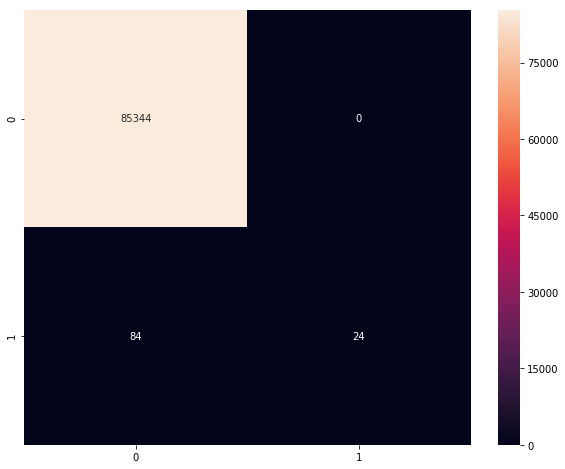

In [18]:
acc = accuracy_score(y_true, y_pred)
print("The prediction accuracy is %.2f%%"%(acc*100))

cm = confusion_matrix(y_true, y_pred)
cm.shape
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
#sn.heatmap(df_cm, annot=True,fmt='d');